# Learn to Score a Tic-Tac-Toe Board by Example

## Introduction 


We want to use machine learning (ML) to support intelligent agents playing Tic-Tac-Toe (see [rules](https://en.wikipedia.org/wiki/Tic-tac-toe)). 
Games are sequential decision making problems but we consider here a much simpler problem that looks only at
one board at a time. The idea is to use supervised learning train a classifier that can **predict if the current board will
lead to winning the game.**

To apply supervised learning we assume:
1. There exists an unknown function $f$ that maps a board $x$ to one of the three classes $y \in {win, draw, loss}$.
2. Since the actual game outcome depends not just on the current board but also on how both players finish the game,
$f$ is stochastic. This means the same board can lead to a win, a loss or a draw. Better boards are just more likely
to lead to a win. ML can deal with stochastic functions $f$.
3. We can create training data by observing (or simulating) games and recording all board positions as the matrix $X$ and if they lead to a win, loss or draw as the vector $y$. 


Classifiers can now learn a function $\hat{y} = h(x)$ where hopefully $\hat{y} \approx y$. 
Most classifiers will make the prediction for a board $x$ by first estimating the conditional probabilities
$P(y = win | x)$, $P(y = loss | x)$, $P(y = draw | x)$ and then picking the class with the 
largest probability (MAP decision).
That is:

$$argmax_{y\in\{win, loss, draw\}} P(y | x)$$
 
We can therefore use 
1. the prediction $y$ to indicate what outcome the game starting for the board has, and 
2. the conditional probabilities to estimate the expected utility of a board using 
   $$E[U(x)] = P(y = win | x) \times 1 + P(y = draw | x) \times 0 + P(y = loss | x) \times -1$$
 
The ML model can be used in several ways.   
   - We can use $E[U(x)]$ as the heuristic evaluation function for Heuristic Minimax Search.
   - We can create all possible boards by trying all possible next moves. The best move leads to the 
      board with the largest $E[U(x)]$. This can be used in an agent to play the game or as the
      playout policy for better simulated games used in Pure Monte Carlo Search/Monte Carlo Tree Search.


The training data is typically generated using simulation which also uses a playout strategy. We will use a 
simple random policy. An even better approach would be to use "self-play." Here the current ML model is used as the playout policy for two copies of the agent playing each other (it is called self-play because the agent basically plays itself). We update the models after each new game finishes and keep on playing. The idea is that the agent will generate better and better data to improve the model. Considerations for self-play including temporal credit assignment and the need to introduce variability into the process can be found in [Tesauro (1995)](https://dl.acm.org/doi/10.1145/203330.203343).

## Implementation

The code for the basic functions used for search are implemented in [tictactoe.py](tictactoe.py). 

In [4]:
from tictactoe import empty_board, actions, result, terminal, utility, other, show_board
from tictactoe import random_player, play 

In [5]:
%precision 3
%pip install -q numpy pandas matplotlib scikit-learn

import numpy as np
import pandas as pd
import math

Note: you may need to restart the kernel to use updated packages.


### Create Training Data using Playouts

We need to create board as the matrix $X$ and the game results as vector $y$. Note that each player sees different 
boards and we need to train a model for a specific player. Here we create data to train a model for player x
by only using the boards resulting from a move of that player.  

ML algorithms need numeric inputs.
To describe $x$ for the learning algorithm, I translate empty cells to 0, `x` to 1 and `o` to -1.

In [6]:
tr = {' ': 0, 'x': 1, 'o': -1} # I translate the board into numbers

def encode_state(state):
    """Represent the board as a vector of numbers."""
    return [tr[s] for s in state]

We will start with a **randomized playout policy.**

In [7]:
def playout_policy_random(state, player = 'x'):
    return np.random.choice(actions(state))
    
playout_policy = playout_policy_random
playout_policy(empty_board())

8

Record a single game for player x.

In [8]:
def playout_record(player = 'x'):
    """Run a playout and record the boards after the player's move."""
    state = empty_board()
    current_player = 'x'
    
    boards = []
    
    while(True):
        # reached terminal state?
        u = utility(state, player)
        if u is not None: return(boards, [u] * len(boards))
  
        a = playout_policy(state, current_player)
        state = result(state, current_player, a)   
  
        if current_player == player:
            boards.append(encode_state(state))

        # switch between players
        current_player = other(current_player)

playout_record()

([[0, 1, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 0, 1, 0, 0, -1, 0, 0],
  [0, 1, 0, 1, 0, 0, -1, 1, -1],
  [-1, 1, 0, 1, 1, 0, -1, 1, -1]],
 [1, 1, 1, 1])

Run `N` playouts and create a pandas dataframe for `X` and a numpy array for `y`. These data structures work for `sklearn`. 

In [9]:
def create_data(N = 100, record = 'x'):
    board = []
    utility = []
    
    for i in range(N):
        b, u = playout_record(record)
        board.extend(b)
        utility.extend(u)
        
    return [pd.DataFrame(board), np.array(utility)]


np.random.seed(1234)

X, y = create_data(2000)

print("X:")
display(X)

print("y:")
display(y)

X:


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,1,-1,0
2,0,0,0,1,0,-1,1,-1,1
3,-1,0,1,1,0,-1,1,-1,1
4,-1,1,1,1,-1,-1,1,-1,1
...,...,...,...,...,...,...,...,...,...
8336,-1,1,1,1,-1,-1,-1,1,1
8337,0,0,0,0,0,0,0,1,0
8338,-1,1,0,0,0,0,0,1,0
8339,-1,1,0,0,-1,1,0,1,0


y:


array([ 0,  0,  0, ..., -1, -1, -1])

Each row in `X` is a board and the values in `y` are the corresponding outcome in the simulated game.

### Train a Model

We train an artificial neural network (ANN) here, but other models like logistic regression or decision trees can also be used.

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

Split the data in training and testing data.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

We learn an artificial neural network (called Multi-layer Perceptron classifier in scikit-learn).
The classifier will also give us access to the predicted conditional probabilities which we will use to calculate the 
expected utility for the evaluation function.

See
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

ANNs are popular for this kind of task but other classification models can also be used (e.g., decision trees).

In [12]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
                    hidden_layer_sizes = (100),
                    max_iter = 1000
                    ) 
                    
%time mlp.fit(X_train, y_train)

CPU times: user 6.85 s, sys: 0 ns, total: 6.85 s
Wall time: 6.85 s


MLPClassifier(hidden_layer_sizes=100, max_iter=1000)

Model size as number of neurons oer layer and total number of weights.

In [13]:
print("Layer 1:", np.shape(mlp.coefs_[0]))
print("Layer 2:", np.shape(mlp.coefs_[1]))

print("Total number of weights:", np.product(np.shape(mlp.coefs_[0])) + np.product(np.shape(mlp.coefs_[1])))

Layer 1: (9, 100)
Layer 2: (100, 3)
Total number of weights: 1200


Test the model against the test data.

In [14]:
pred = mlp.predict(X_test)

print("y_test:\t", list(y_test)[0:10])
print("pred:\t",   pred[0:10])

print("Accuracy:", accuracy_score(pred, y_test))

y_test:	 [-1, 1, -1, 1, -1, 1, 0, 1, 0, 1]
pred:	 [ 1  1  1  1  1 -1  0  1  0  1]
Accuracy: 0.6554823247453565


__Note:__ The accuracy is not great since we have many boards with only a few moves on it. Since these boards can easily lead to wins, losses or ties, they produce many errors.

Here is the number of empty cells for each board in the test set.

In [27]:
(X_test == 0).sum(axis=1).value_counts()

8    430
6    393
4    374
2    319
0    153
Name: count, dtype: int64

Test only on boards that have only two cells left to play.

In [38]:
take = list((X_test == 0).sum(axis=1) == 2)

X_test2 = X_test[take]
y_test2 = y_test[take]

In [39]:
pred2 = mlp.predict(X_test2)
print(f"Accuracy:", accuracy_score(pred2, y_test2))

Accuracy: 0.7586206896551724


__More Notes:__ 

* The board is symmetric. You could use deep learning with convolution layers to create better models.
* The tic-tac-toe board is small and we used 2000 playouts. This covers a large space of the search space. If you have a more complicated game, 
    then you would need to do self-play to learn better and better playout policies.

## Some Tests

We evaluate some boards where `x` just made a move. The classifier tries to predict the most likely outcome
of the game as -1 = `o` wins, 0 = draw, and 1 = `x` wins. The classifier can also predict the probability of the three possible outcomes. We can use these probabilities as weights to calculate the expected utility in the range $[-1,1]$.

In [40]:
def print_eval_board(board):
    print("Board:")
    show_board(board)

    pred = mlp.predict(pd.DataFrame([encode_state(board)]))
    print("\nPredicted game outcome:", pred)

    probs = mlp.predict_proba(pd.DataFrame([encode_state(board)]))
    print("Predicted probability [loss, draw, win]:", np.round(probs, 2))
    print("Expected utility: %+1.2f" % np.sum(probs * [-1,0,1]))

### x will win

Board:


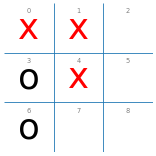


Predicted game outcome: [1]
Predicted probability [loss, draw, win]: [[0.09 0.   0.91]]
Expected utility: +0.83


In [19]:
board = ['x', 'x', ' ',
         'o', 'x', ' ',
         'o', ' ', ' ']

print_eval_board(board)

### x made a mistake and will lose

Board:


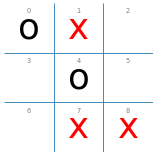


Predicted game outcome: [-1]
Predicted probability [loss, draw, win]: [[0.37 0.31 0.33]]
Expected utility: -0.04


In [20]:
board = ['o', 'x', ' ',
         ' ', 'o', ' ',
         ' ', 'x', 'x']
    
print_eval_board(board)

### This is going to be a draw

Board:


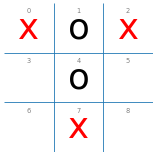


Predicted game outcome: [0]
Predicted probability [loss, draw, win]: [[0.1  0.63 0.27]]
Expected utility: +0.17


In [21]:
board = ['x', 'o', 'x',
         ' ', 'o', ' ',
         ' ', 'x', ' ']

print_eval_board(board)

## Using the Predictions to find the Best Move

The predict function can be used for
   - the heuristic evaluation function for Heuristic Minimax Search.
   - a better playout policy for simulated games used in Pure Monte Carlo Search/Monte Carlo Tree Search. If we use it as a playout strategy to create more data for learning better ML models, then this is called _self-play_. 

I show here how to use the model as a heuristic evaluation function for all boards that the player `x` can get to with its next move. The player then chooses the move with the highest heuristic value (printed as "best action"). This is equivalent to heuristic minimax search with a cutoff at depth 1. 

In [22]:
def eval_fun_ML(state, player = 'x'):
    p = mlp.predict_proba(pd.DataFrame([encode_state(state)]))
    val = np.sum(p * [-1, 0 , 1])
    return val
    

def best_action(state, player = 'x', verbose = False):  
    action = None
    value = -math.inf

    for a in actions(state) : 
        b = result(state, player, a)
        val = eval_fun_ML(b, player)
        if (verbose):
            print("%s chooses %d; predicted utility = %+1.2f" % (player, a, val))

        if val > value:
            value = val
            action = a
        
    return action

### Empty board: Place in the center (or at least a corner)

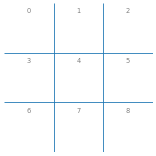

x chooses 0; predicted utility = +0.33
x chooses 1; predicted utility = +0.19
x chooses 2; predicted utility = +0.28
x chooses 3; predicted utility = +0.20
x chooses 4; predicted utility = +0.51
x chooses 5; predicted utility = +0.22
x chooses 6; predicted utility = +0.35
x chooses 7; predicted utility = -0.01
x chooses 8; predicted utility = +0.39
Best action: 4
CPU times: user 19.1 ms, sys: 32.7 ms, total: 51.8 ms
Wall time: 17 ms


In [23]:
board = empty_board()
show_board(board)
%time print("Best action:", best_action(board, verbose = True))

### Play 7 to avoid a loss

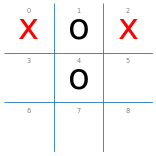

x chooses 3; predicted utility = -0.11
x chooses 5; predicted utility = -0.40
x chooses 6; predicted utility = -0.22
x chooses 7; predicted utility = +0.17
x chooses 8; predicted utility = -0.25
Best action: 7
CPU times: user 16.7 ms, sys: 14.7 ms, total: 31.4 ms
Wall time: 10.4 ms


In [24]:
board = ['x', 'o', 'x',
         ' ', 'o', ' ',
         ' ', ' ', ' ']
show_board(board)
%time  print("Best action:", best_action(board, verbose = True))

### Play 4 to win

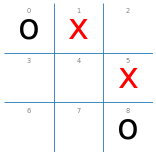

x chooses 2; predicted utility = -0.93
x chooses 3; predicted utility = -0.44
x chooses 4; predicted utility = +0.31
x chooses 6; predicted utility = +0.65
x chooses 7; predicted utility = -0.23
Best action: 6
CPU times: user 11.6 ms, sys: 11 ms, total: 22.6 ms
Wall time: 7.44 ms


In [25]:
board = ['o', 'x', ' ',
         ' ', ' ', 'x',
         ' ', ' ', 'o']
show_board(board)
%time  print("Best action:", best_action(board, verbose = True))

Interesting: The learned evaluation function may think that leaving 6 to o is a really bad idea.

## Some Concluding Notes 

* The learned evaluation function is not perfect.
* Tic-tac-toe is easy and learning an evaluation function for more complex games can be a lot harder.